In [1]:
if length(LOAD_PATH)<3

#    addprocs(3)
    push!(LOAD_PATH,"/Users/wrsweeney/Box Sync/Research/SALT")
    
#    addprocs(20)
#    push!(LOAD_PATH,"/home/wrs28/Documents/SALT")
end

using SALT_2d
using SALT_2d_Parallel
using PyPlot
using NLsolve

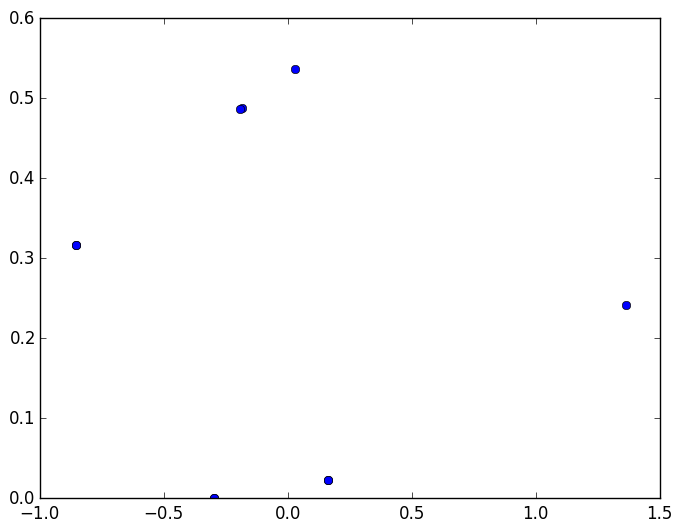

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x111b3f210>

In [2]:
# check CF solver for incoming and outgoing states

inputs = processInputs()
η,u = computeCFs(inputs, inputs["k₀"], 2; bc = "out")
β,v = computeCFs(inputs, inputs["k₀"], 10; bc = "in")
plot(real(β),imag(β),"o")

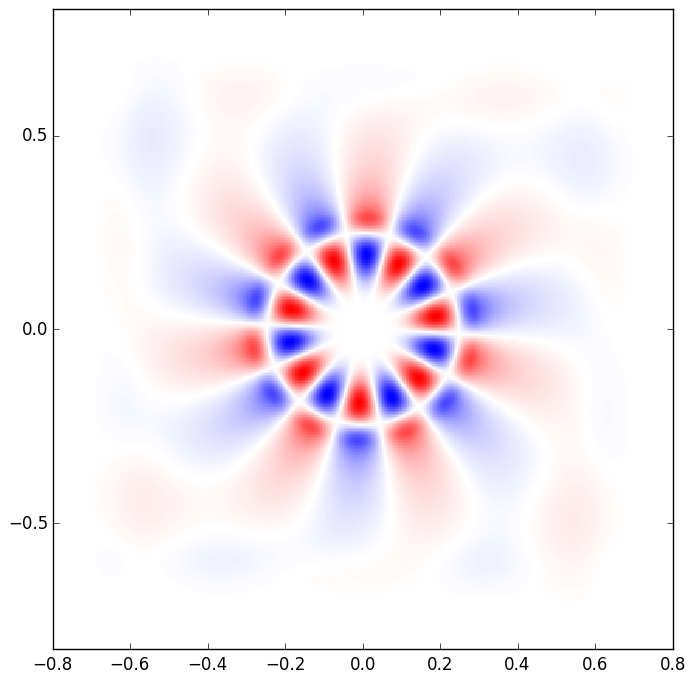

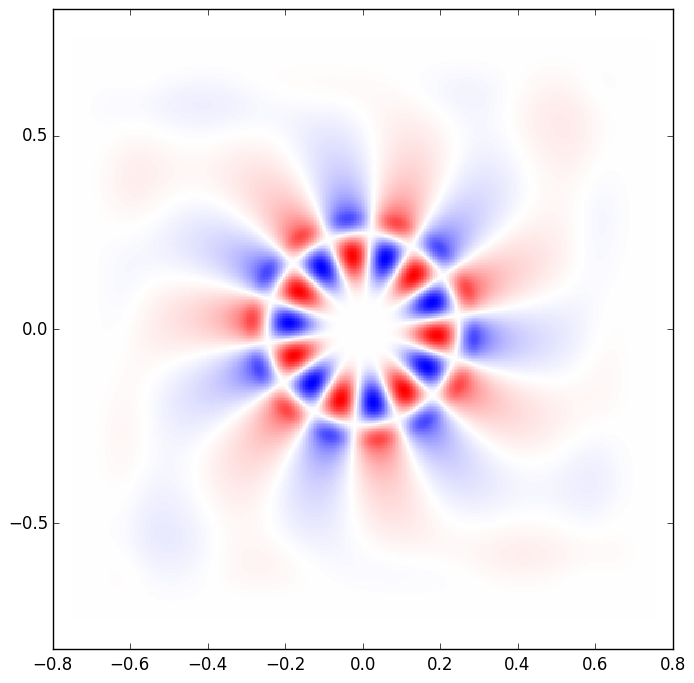

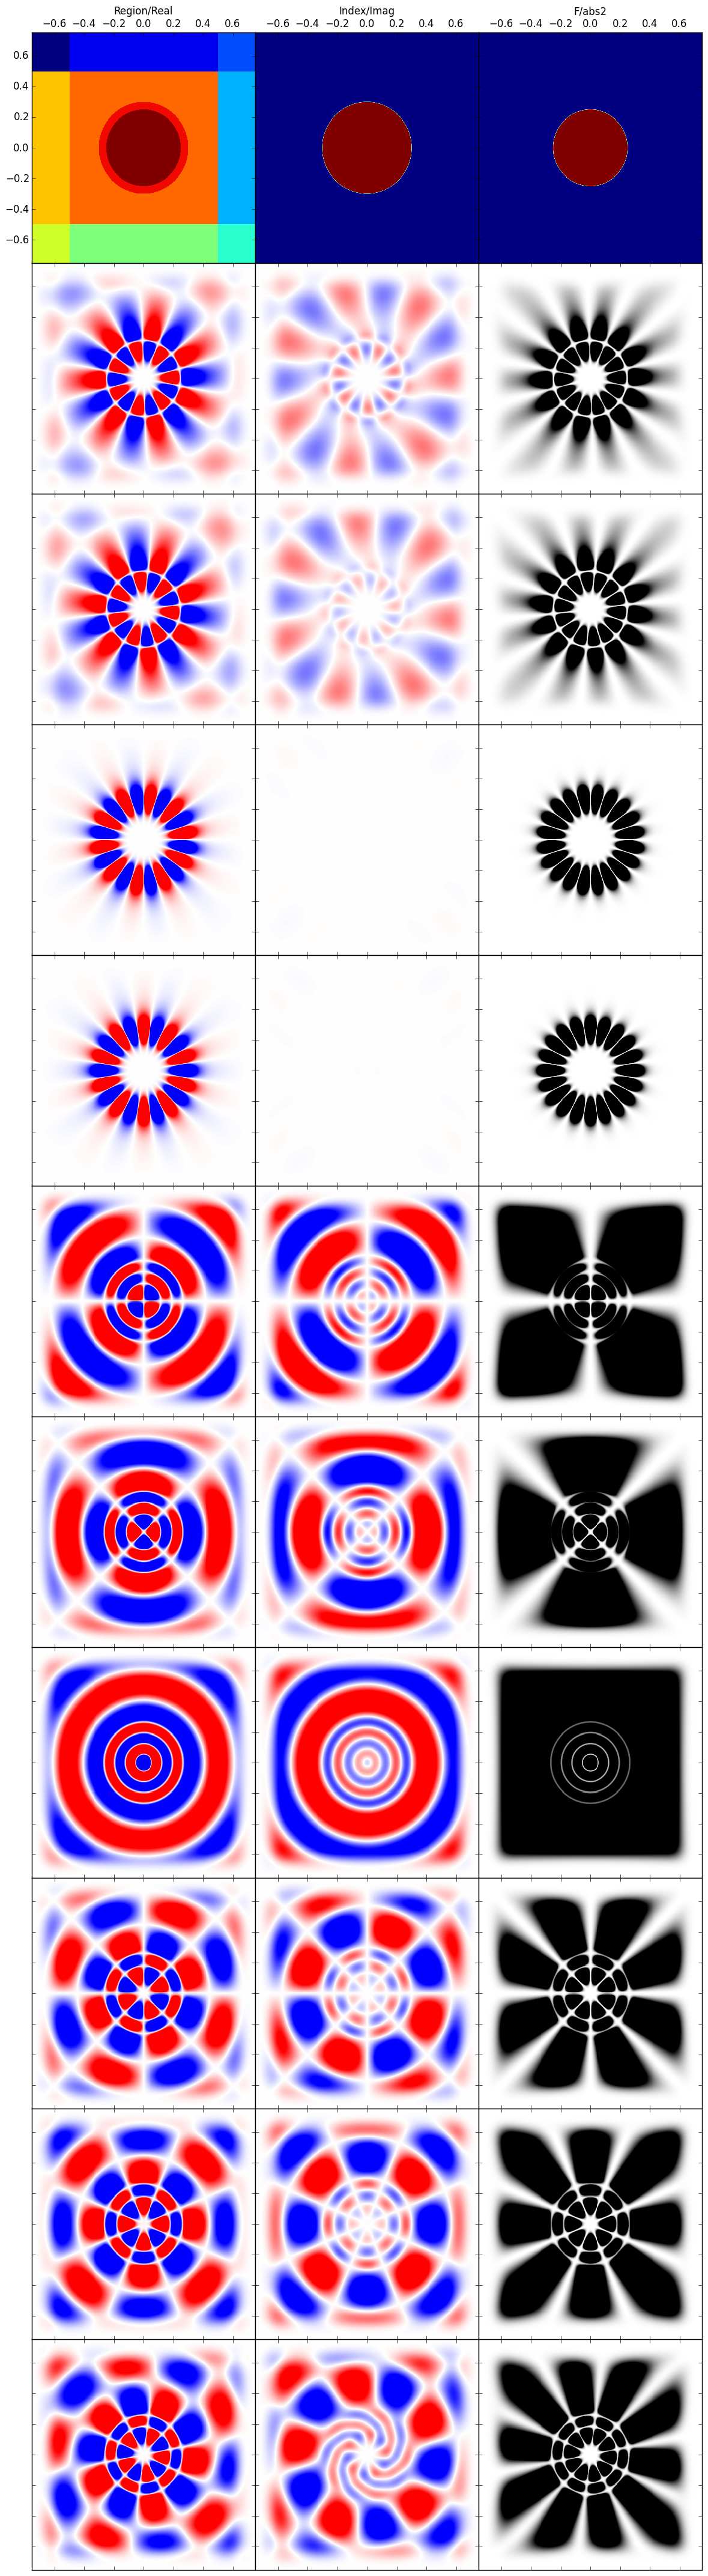

In [3]:
# plot CF results (make sure plotting routine works)
wavePlot(u,inputs; array = false, how = real)
wavePlot(v,inputs)

In [4]:
N = 15
inputs = processInputs()
k,ψ = computePolesL(inputs, inputs["k₀"] , N; F = 0.,truncate = true)
;

In [5]:
# compute exact resonances of disk

n = 3
R = .3

M = 16
Z = NaN*zeros(Complex128,M+1,25)

for m in 0:M
    function f!(x,fvec)
    
        k = x[1]+1im*x[2]
    
        f = n*(besselj(m-1,n*k*R)-besselj(m+1,n*k*R))/besselj(m,n*k*R) - (hankelh1(m-1,k*R)-hankelh1(m+1,k*R))/hankelh1(m,k*R)
     
        fvec[1] = real(f)
        fvec[2] = imag(f)

    end


    x = linspace(0,50,1e4)
    j = besselj(m,x[2:end])-besselj(m,x[1:end-1])
    zero_inds = find(sign(j[1:end-1]).*sign(j[2:end]).<0)
    for z in 1:length(zero_inds)
        Z[m+1,z] = x[zero_inds[z]]
        kk = nlsolve(f!,[real(Z[m+1,z]),0])
        Z[m+1,z] = kk.zero[1]+1im*kk.zero[2]    
    end
    
end

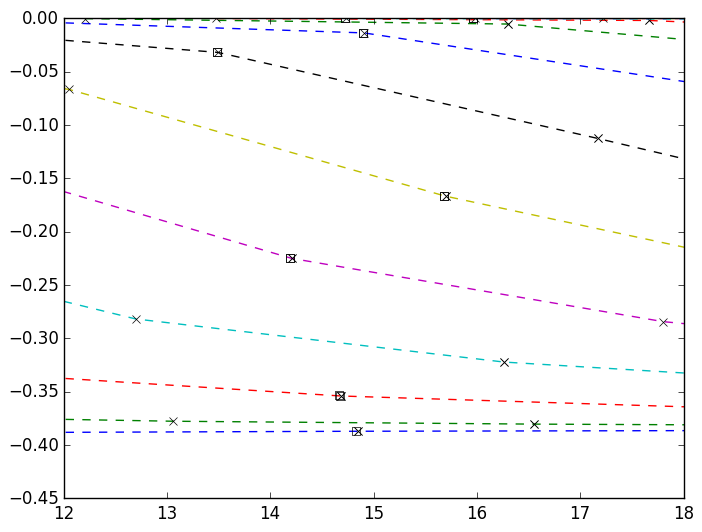

In [6]:
# compare computed vs exact resonances for disk
# lines connect fixed m values

#plot(real(k),log10(-imag(k)),"s",mfc="none",mec="k")
plot(real(Z)',imag(Z)',"x--",mec="k")
plot(real(k),imag(k),"s",mfc="none",mec="k")
xlim([12,18])
;

3
6


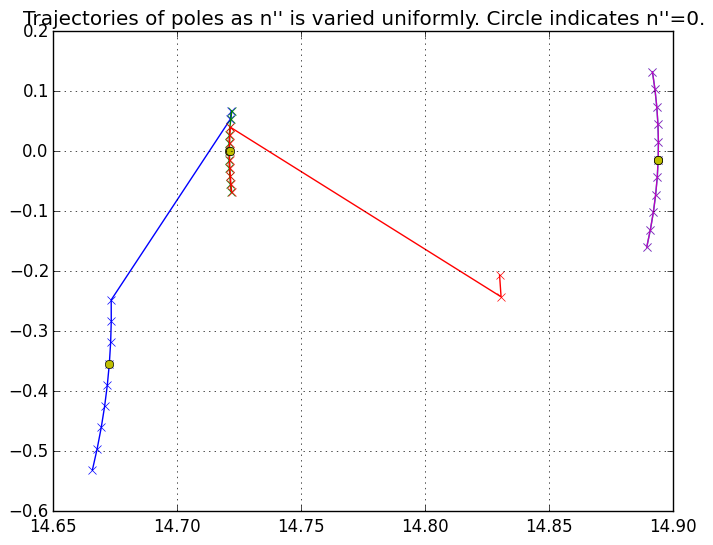

In [7]:
#verify computePolesL

inputs = processInputs()

nD = 11
nPoles = 5
D = linspace(-0.25,0.25,nD)

kp = NaN*zeros(Complex128,nPoles,nD)
ψp = NaN*zeros(Complex128,prod(inputs["N_ext"]),nPoles,nD)
for d in 1:nD
    if d/3==round(d/3)
        println(d)
    end
    inputs["D₀"] = D[d]
    kp[:,d],ψp[:,:,d] = computePolesL(inputs, inputs["k₀"], nPoles; F=1.)
    perm = sortperm(conj(kp[:,d]),by=real)
    kp[:,d] = kp[perm,d]
    ψp[:,:,d] = ψp[:,perm,d]
end

figure(1)
title("Trajectories of poles as n'' is varied uniformly. Circle indicates n''=0.")
plot(real(kp)',imag(kp)',"-x")
plot(real(kp[:,ceil(Int,nD/2)]),imag(kp[:,ceil(Int,nD/2)]),"o")
grid(true)
;

3
6


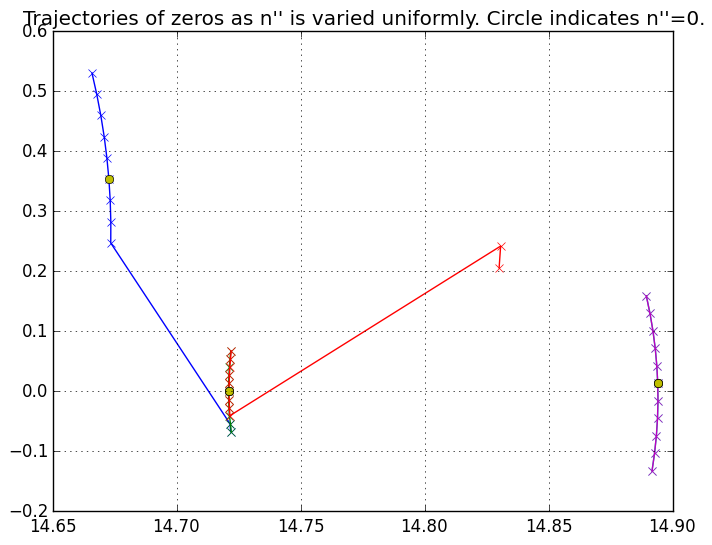

In [8]:
#verify computeZerosL

inputs = processInputs()

nD = 11
nZeros = 5
D = linspace(-0.25,0.25,nD)

kz = NaN*zeros(Complex128,nZeros,nD)
ψz = NaN*zeros(Complex128,prod(inputs["N_ext"]),nZeros,nD)
for d in 1:nD
    if d/3==round(d/3)
        println(d)
    end
    inputs["D₀"] = D[d]
    kz[:,d],ψz[:,:,d] = computeZerosL(inputs, inputs["k₀"], nZeros; F=1.)
    perm = sortperm(conj(kz[:,d]),by=real)
    kz[:,d] = kz[perm,d]
    ψz[:,:,d] = ψz[:,perm,d]
end

figure(1)
title("Trajectories of zeros as n'' is varied uniformly. Circle indicates n''=0.")
plot(real(kz)',imag(kz)',"-x")
plot(real(kz[:,ceil(Int,nD/2)]),imag(kz[:,ceil(Int,nD/2)]),"o")
grid(true)
;

[1,1]
14.721134785838359 - 1.1370590353750027e-5im
14.721134785838359 - 1.1370590353750027e-5im
[1,2]
14.721134785838359 - 1.1370590353750027e-5im
14.721369273342276 + 0.00295716578673099im
[1,3]
14.721369273342276 + 0.00295716578673099im
14.72160300861637 + 0.00590819655576029im
[1,4]
14.72160300861637 + 0.00590819655576029im
14.72183602515866 + 0.008842034068834877im
[1,5]
14.72183602515866 + 0.008842034068834877im
14.722068354991375 + 0.011758981715090556im
[1,6]
14.722068354991375 + 0.011758981715090556im
14.722300028697072 + 0.014659334199657124im
[1,7]
14.722300028697072 + 0.014659334199657124im
14.722531075496542 + 0.017543377886111555im
[1,8]
14.722531075496542 + 0.017543377886111555im
14.722761523321068 + 0.020411391121797517im
[1,9]
14.722761523321068 + 0.020411391121797517im
14.722991398880769 + 0.023263644547108473im
[1,10]
14.722991398880769 + 0.023263644547108473im
14.723220727729373 + 0.026100401389633692im
[2,1]
14.720930045250457 - 1.1792818473630813e-5im
14.7209300452

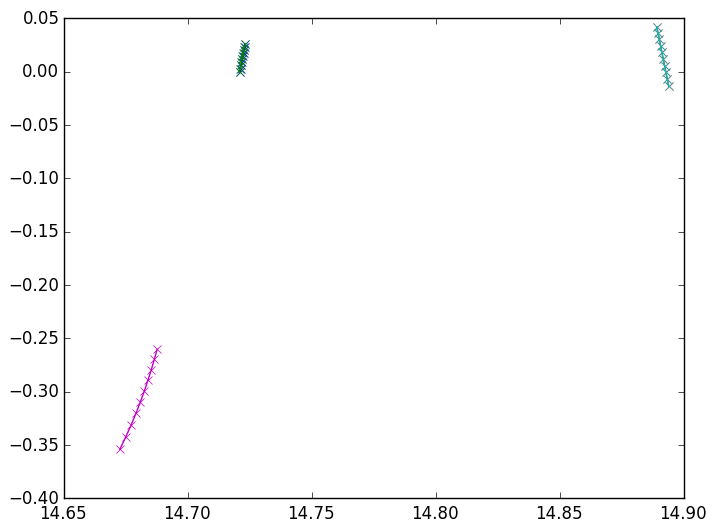

14.687711213175952 - 0.26010037456547164im


In [9]:
#verify computePolesNL1

inputs = processInputs()

nD = 10
D = linspace(0,0.1,nD)
nPoles = 5

kp_init, ψp_init = computePolesL(inputs,inputs["k₀"],nPoles;F=1.)

kp = NaN*zeros(Complex128,nPoles,nD)
ψp = NaN*zeros(Complex128,prod(inputs["N_ext"]),nPoles,nD)
η = 0

for n in 1:nPoles
    for d in 1:nD
        if d/1==round(d/1)
            println([n,d])
        end
        
        inputs["D₀"] = D[d]

        if d==1
            kp[n,d],ψp[:,n,d],η,conv = computePolesNL1(inputs, kp_init[n]; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50)
        else
            kp[n,d],ψp[:,n,d],η,conv = computePolesNL1(inputs, kp[n,d-1] ; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50, η_init = η, u_init = ψp[:,n,d-1] )
        end

    end
end

figure(1)
plot(real(kp)',imag(kp)',"-x")
;

[1,3]
[1,6]
[1,9]
[2,3]
[2,6]
[2,9]
[3,3]
[3,6]
[3,9]
[4,3]
[4,6]
[4,9]
[5,3]
[5,6]


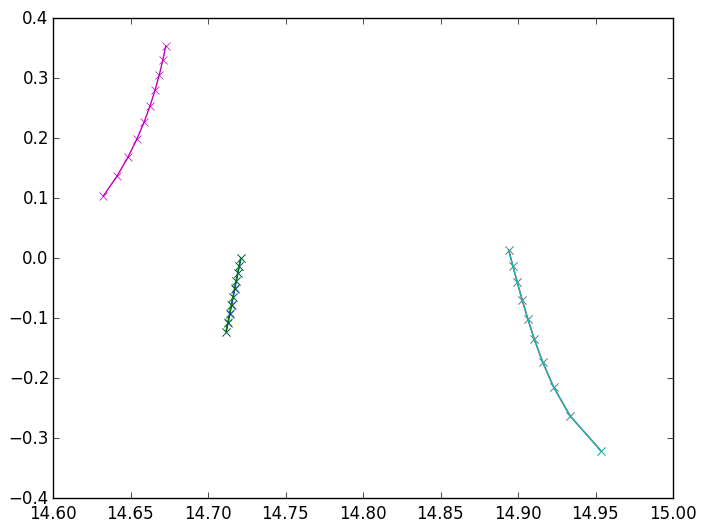

[5,9]


In [10]:
#verify computeZerosNL1

inputs = processInputs()

nD = 10
D = linspace(0,-0.1,nD)
nZeros = 5

kz_init, ψz_init = computeZerosL(inputs,inputs["k₀"],nZeros;F=1.)

kz = NaN*zeros(Complex128,nZeros,nD)
ψz = NaN*zeros(Complex128,prod(inputs["N_ext"]),nZeros,nD)
β = 0

for n in 1:nZeros
    for d in 1:nD
        if d/3==round(d/3)
            println([n,d])
        end
        inputs["D₀"] = D[d]
        if d==1
            kz[n,d],ψz[:,n,d],β,conv = computeZerosNL1(inputs, kz_init[n]; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50)
        else
            kz[n,d],ψz[:,n,d],β,conv = computeZerosNL1(inputs, kz[n,d-1] ; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50, β_init = β, v_init = ψz[:,n,d-1] )
        end
    end
end

figure(1)
plot(real(kz)',imag(kz)',"-x")   
;

In [ ]:
# verify computePolesNL2

inputs = processInputs()

nD = 10
D = linspace(0,0.1,nD)

kpp1 = Array(Any,nD)
kpp2 = Array(Any,nD)

tic()
for d in 1:nD
    println(d)
    inputs["D₀"] = D[d]
    kpp1[d] = computePolesNL2(inputs, inputs["k₀"], (1.0,0.5); Nq=50, nPoles=4, F=1., R_min = .01)
end
toc()

#tic()
#for d in 1:nD
#    println(d)
#    inputs["D₀"] = D[d]
#    kpp2[d] = computePolesNL2_parallel(inputs, inputs["k₀"], (2.5,1.4); Nq=150, nPoles=7, F=1., R_min = .01)
#end
#toc()

for d in 1:nD
    plot(real(kpp1[d]),imag(kpp1[d]),"s")
    plot(real(kpp2[d]),imag(kpp2[d]),"o")
end
;

1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
# TEST SPA scattered
inputs["a"] = 1.
inputs["D₀"] = .2
ψ = solve_SPA(inputs, real(ω1[1]), z₀=.15im)

In [ ]:
# TEST SCATTER SOLVER
Ψ = solve_scattered(inputs, real(ω1[1]); isNonLinear=true,ψ_init = ψ)

In [ ]:
# TEST SPA Lasing
a = copy(inputs["a"])
inputs["a"] = 0.
inputs["D₀"] = D2
ψ₊,ψ₋,dummy = solve_SPA(inputs, real(ω1[1]),z₀₊=.0001im,z₀₋=.0001im)

plot(inputs["x"],abs2(ψ₊[inputs["x_inds"]]))
hold(true)
plot(inputs["x"],abs2(ψ₋[inputs["x_inds"]]));

In [ ]:
# TEST LASING SOLVER
ψ₊ = 1im*ψ₊/exp(1im*angle(ψ₊[1]))
ψ₋ = 1im*ψ₋/exp(1im*angle(ψ₋[1]))
ψ,ω = solve_lasing(inputs, inputs["D₀"], ψ_init=ψ₊,ω_init = real(ω1[1]), inds = 14)
ω